In [1]:
import sys

import pandas 
import scipy

import matplotlib.pyplot
import seaborn

import networkx

sys.path.append("../scripts")
from utils import parse_interactome

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [3]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [4]:
def check_pvalue(pvalue):
    if pvalue < 0.0001:
        return "p-value < 0.0001"
    if pvalue < 0.001:
        return "p-value < 0.001"
    if pvalue < 0.01:
        return "p-value < 0.01"
    if pvalue < 0.05:
        return "p-value < 0.05"
    else:
        return "p-value >= 0.05"

In [5]:
def compare_scores(scores, scores_left_out):
    scores = scores.copy()
    for left_out in scores_left_out:
        del scores[left_out]

    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, pvalue = scipy.stats.ranksums(df_scores['score'].values, df_scores_left_out['score'].values, alternative='less')

    pvalue_thresh = check_pvalue(pvalue)

    print(stat, pvalue)

    return df_compare, pvalue_thresh

In [6]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [7]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [127]:
PHENOTYPE = "MMAF"
ALPHA = 0.5
D_MAX = 10
ALPHA_NORM = 10


#### Load the necessary data

In [128]:
interactome = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/New_centrality_v6/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_v6/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [129]:
df_compare, p_value = compare_scores(scores, scores_leave_one_out)

-2.943349433519856 0.001623408574042539


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.5,   d=10,    alpha_norm=10')

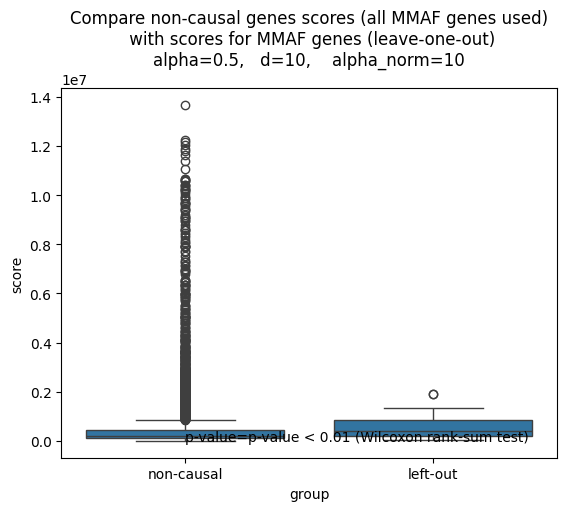

In [130]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")
# matplotlib.pyplot.ylim(0,2)

In [131]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
scores_sorted

{'ENSG00000219481': 13665100.478638913,
 'ENSG00000149972': 12245456.472672049,
 'ENSG00000176371': 12176375.92590651,
 'ENSG00000101441': 12040347.641435945,
 'ENSG00000145740': 11887452.399754008,
 'ENSG00000054277': 11775593.414548652,
 'ENSG00000122367': 11639150.37741656,
 'ENSG00000124104': 11376550.862304905,
 'ENSG00000181523': 11059525.533009095,
 'ENSG00000130433': 10663313.550705163,
 'ENSG00000157388': 10663313.550705163,
 'ENSG00000204228': 10629760.251086634,
 'ENSG00000145681': 10570594.978231128,
 'ENSG00000155858': 10563328.554599099,
 'ENSG00000258992': 10421258.626912706,
 'ENSG00000163273': 10397954.838072656,
 'ENSG00000119004': 10368800.411963873,
 'ENSG00000111962': 10277862.566386426,
 'ENSG00000241058': 10243224.317817193,
 'ENSG00000162971': 10214339.284554647,
 'ENSG00000239388': 10214339.284554647,
 'ENSG00000138722': 10148436.705527715,
 'ENSG00000187193': 10068212.57752706,
 'ENSG00000176907': 9962645.778541813,
 'ENSG00000099834': 9898988.554383585,
 'ENS

In [132]:
len(scores), len(scores_sorted)

(14393, 14393)

#### Analyze new candidates from 13/02/2024

In [133]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [134]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [135]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [136]:
scores_new_candidates

{'ENSG00000162994': 904917.9197304753,
 'ENSG00000025293': 215801.4811032888,
 'ENSG00000164287': 168909.2222640211,
 'ENSG00000188732': 235960.31638504774,
 'ENSG00000128310': 646818.6593934547,
 'ENSG00000165115': 358452.624931552,
 'ENSG00000180376': 292675.4298592352,
 'ENSG00000133101': 125679.80994320949,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 468453.31699339295,
 'ENSG00000136449': 565570.9755639647,
 'ENSG00000078814': 383053.89618281747,
 'ENSG00000165698': 329862.17864023434,
 'ENSG00000170469': 396212.7462861076,
 'ENSG00000132122': 178871.44086531654,
 'ENSG00000139908': 499923.12124978093,
 'ENSG00000120440': 1235371.3889754757}

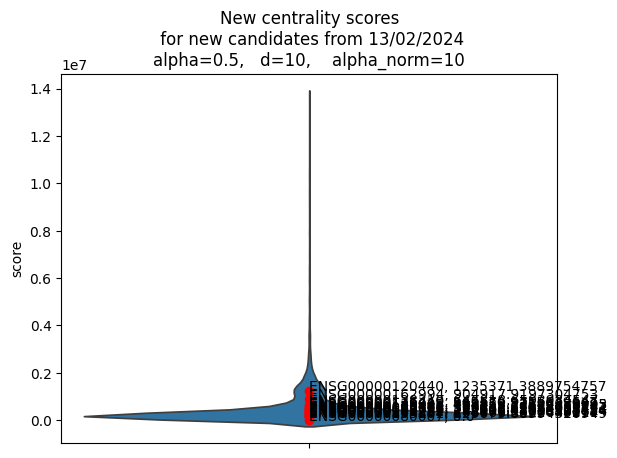

In [137]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")

### Compare New centrality with other centralities (degree, betweenness)

In [144]:
CENTRALITY = "betweenness"

In [145]:
scores_leave_one_out_sorted = {node: score for node, score in sorted(scores_leave_one_out.items(), key=lambda item: item[0], reverse=True)}

In [146]:
scores_centrality = parse_scores(f"/home/kubicaj/calc/output/{CENTRALITY}_centrality/{PHENOTYPE}/scores.tsv")
scores_centrality = {node: score for node, score in scores_centrality.items() if node in scores}
scores_centrality_sorted = {node: score for node, score in sorted(scores_centrality.items(), key=lambda item: item[0], reverse=True)}

scores_centrality_causal = {node: score for node, score in scores_centrality.items() if node in scores_leave_one_out}
scores_centrality_causal_sorted = {node: score for node, score in sorted(scores_centrality_causal.items(), key=lambda item: item[0], reverse=True)} 

In [147]:
len(scores_sorted.values()), len(scores_centrality_sorted.values())

(14393, 14393)

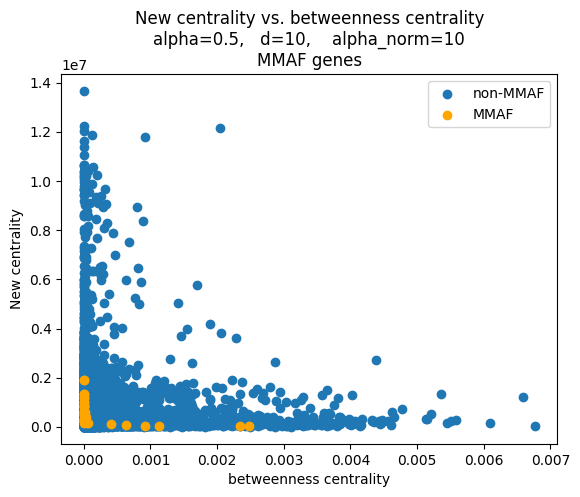

In [148]:
matplotlib.pyplot.scatter(x=scores_centrality_sorted.values(), y=scores_sorted.values(), label=f"non-{PHENOTYPE}")
matplotlib.pyplot.scatter(x=scores_centrality_causal_sorted.values(), y=scores_leave_one_out_sorted.values(), c='orange', label=f"{PHENOTYPE}")
matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.legend()

In [149]:
0.5**10

0.0009765625